# RFECV multi-class prediction

In [11]:
import pathlib

import anndata
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.metrics import (balanced_accuracy_score, confusion_matrix,
                             fbeta_score, make_scorer)
from sklearn.model_selection import StratifiedKFold

## Parameters

In [1]:
cluster_col = 'SubType'
test_portion = 0.1
random_seed = 0
n_estimators = 100
n_estimators_final = 500
n_jobs = 30
n_splits = 5
cluster_order_path = None

In [12]:
output_dir = 'Model'
output_dir = pathlib.Path(output_dir)
output_dir.mkdir(exist_ok=True)

## Load Marker Adata

In [3]:
adata = anndata.read_h5ad('Markers/cluster_markers.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 28077 × 2891 
    obs: 'AllcPath', 'CCC_Rate', 'CG_Rate', 'CG_RateAdj', 'CH_Rate', 'CH_RateAdj', 'FinalReads', 'InputReads', 'MappedReads', 'Region', 'index_name', 'uid', 'BamFilteringRate', 'MappingRate', 'Pos96', 'Plate', 'Col96', 'Row96', 'Col384', 'Row384', 'FACS_Date', 'Slice', 'MajorRegion', 'SubRegion', 'CellClass', 'l1-umap_0', 'l1-umap_1', 'l1-tsne_0', 'l1-tsne_1', 'MajorType', 'l2-umap_0', 'l2-umap_1', 'l2-tsne_0', 'l2-tsne_1', 'SubType', 'l3-umap_0', 'l3-umap_1', 'l3-tsne_0', 'l3-tsne_1', 'L1CellClass', 'class_tsne_0', 'class_tsne_1', 'class_umap_0', 'class_umap_1', 'Order', 'RegionName', 'DetailRegion', 'PotentialOverlap (MMB)', 'Anterior (CCF coords)', 'Posterior (CCF coords)', 'MajorRegionColor', 'SubRegionColor', 'DissectionRegionColor'
    var: 'chrom', 'start', 'end'

## Cluster Order

In [ ]:
if cluster_order_path is not None:
    cluster_order = pd.read_csv(cluster_order_path, header=None, index_col=0).index
else:
    cluster_order = sorted(adata.obs[cluster_col].unique())

## Supervise training

In [7]:
n_cell = adata.shape[0]
n_test = int(n_cell * test_portion)

In [8]:
# separate test and train
test_cells = adata.obs.sample(n_test, random_state=random_seed).index
test_judge = adata.obs_names.isin(test_cells)
train_judge = ~adata.obs_names.isin(test_cells)

In [9]:
test_df = pd.DataFrame(adata[test_judge, :].X,
                       index=adata.obs_names[test_judge],
                       columns=adata.var_names)
test_label = adata.obs.loc[test_judge, cluster_col]

train_df = pd.DataFrame(adata[train_judge, :].X,
                        index=adata.obs_names[train_judge],
                        columns=adata.var_names)
train_label = adata.obs.loc[train_judge, cluster_col]

## Training

In [8]:
estimator = BalancedRandomForestClassifier(n_estimators=n_estimators,
                                           criterion='gini',
                                           max_depth=None,
                                           min_samples_split=2,
                                           min_samples_leaf=2,
                                           min_weight_fraction_leaf=0.0,
                                           max_features='auto',
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           bootstrap=True,
                                           oob_score=False,
                                           sampling_strategy='auto',
                                           replacement=False,
                                           n_jobs=n_jobs,
                                           random_state=random_seed,
                                           verbose=3,
                                           warm_start=False,
                                           class_weight=None)

cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

# TODO change to balanced accuracy score
scoring = make_scorer(balanced_accuracy_score)

clf = RFECV(estimator,
            step=3,
            min_features_to_select=1,
            cv=cv,
            scoring=scoring,
            verbose=3,
            n_jobs=10)

In [ ]:
clf.fit(train_df, train_label)
joblib.dump(clf, 'Model/RFECV.lib')

## Featurs

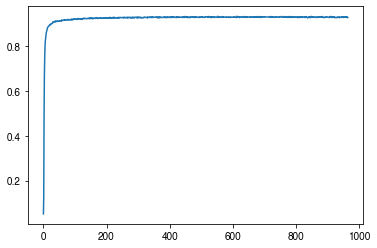

In [14]:
plt.plot(clf.grid_scores_)

In [17]:
feature_to_use = train_df.columns[clf.support_]
print(feature_to_use.size, 'features selected by RFECV')

1655 features selected by RFECV


## Testing

In [18]:
# final pred
pred_label = clf.predict(test_df)

# final pred proba
pred_proba = clf.predict_proba(test_df)
pred_proba = pd.DataFrame(pred_proba, index=test_df.index, columns=clf.classes_)
pred_proba = pred_proba[cluster_order].copy()

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.0s finished


In [74]:
balanced_accuracy_score(test_label, pred_label)

0.9412275766092342

## Confusion matrix

In [27]:
cfm = confusion_matrix(test_label, pred_label, labels=cluster_order)
cfm = pd.DataFrame(cfm, index=cluster_order, columns=cluster_order)

cfm_ratio = cfm / cfm.sum(axis=1)[:, None]

[(0, 78)]

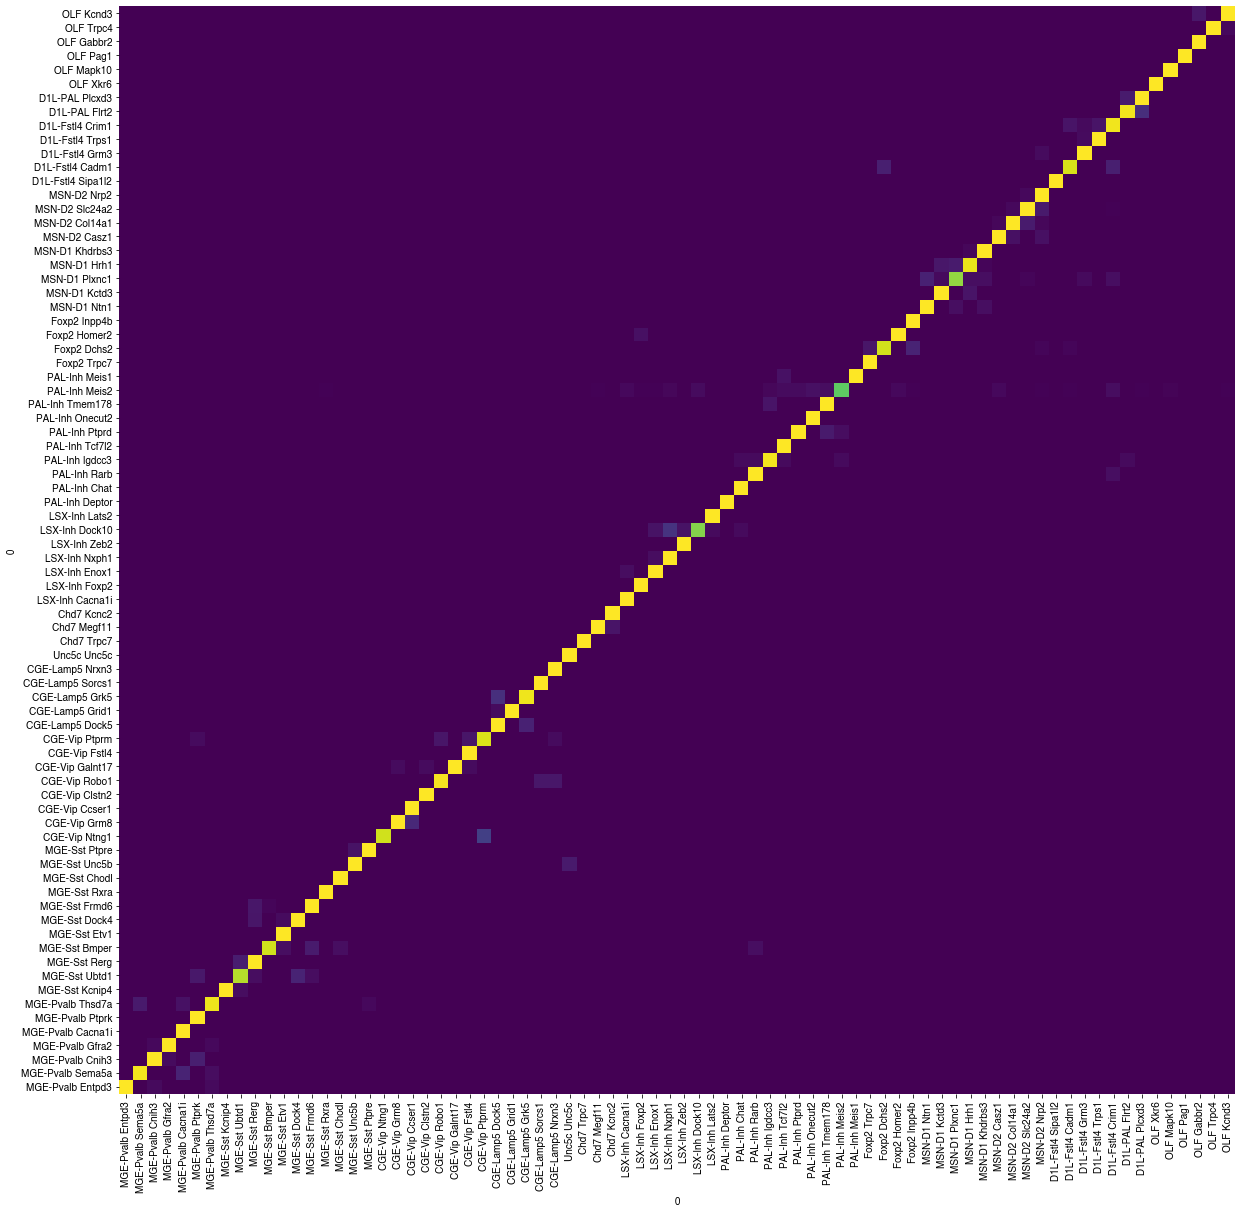

In [30]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(cfm_ratio, cbar=None, vmin=0, vmax=0.9, cmap='viridis')
ax.set(ylim=(0, cfm_ratio.shape[0]))

In [39]:
cluster_order_map = {c: i for i, c in enumerate(cluster_order)}
test_orders = pred_proba.index.map(adata.obs[cluster_col]).map(cluster_order_map)
sort_pred_proba = pred_proba.iloc[test_orders.argsort(), :]

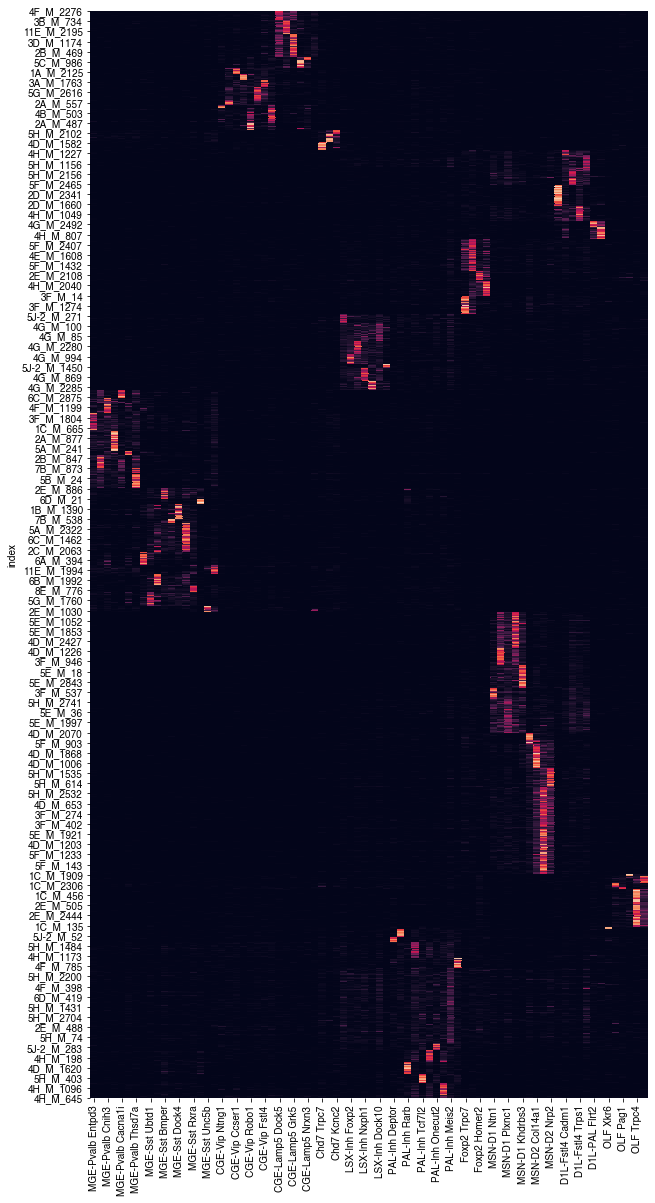

In [49]:
fig, ax = plt.subplots(figsize=(10, 20))
sns.heatmap(sort_pred_proba, ax=ax, cbar=None)

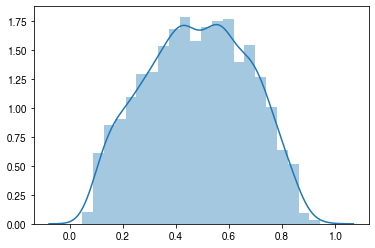

In [57]:
max_proba = []
for cell, cluster in sort_pred_proba.idxmax(axis=1).iteritems():
    max_proba.append(sort_pred_proba.at[cell, cluster])
sns.distplot(max_proba)

## Train final model with RFECV selected feature

In [58]:
selected_train_df = train_df.loc[:, feature_to_use]
selected_test_df = test_df.loc[:, feature_to_use]

In [59]:
# final estimator with larger trees
final_estimator = BalancedRandomForestClassifier(n_estimators=n_estimators_final,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 min_samples_split=2,
                                                 min_samples_leaf=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 bootstrap=True,
                                                 oob_score=False,
                                                 sampling_strategy='auto',
                                                 replacement=False,
                                                 n_jobs=n_jobs,
                                                 random_state=random_seed,
                                                 verbose=3,
                                                 warm_start=False,
                                                 class_weight=None)

In [60]:
final_estimator.fit(selected_train_df, train_label)
joblib.dump(final_estimator, 'Model/FinalClassifier.lib')

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 3 of 1000
building tree 12 of 1000
building tree 2 of 1000
building tree 10 of 1000
building tree 1 of 1000
building tree 28 of 1000
building tree 22 of 1000
building tree 11 of 1000
building tree 6 of 1000
building tree 26 of 1000
building tree 8 of 1000
building tree 5 of 1000
building tree 29 of 1000
building tree 13 of 1000
building tree 21 of 1000
building tree 19 of 1000
building tree 14 of 1000
building tree 30 of 1000
building tree 15 of 1000
building tree 4 of 1000
building tree 27 of 1000
building tree 16 of 1000
building tree 7 of 1000
building tree 18 of 1000
building tree 20 of 1000
building tree 9 of 1000
building tree 25 of 1000
building tree 24 of 1000
building tree 17 of 1000
building tree 23 of 1000
building tree 31 of 1000
building tree 33 of 1000building tree 32 of 1000

building tree 35 of 1000
building tree 37 of 1000
building tree 34 of 1000
building tree 48 of 1000
building tree 38 of 1000
building tree 36 of 1000
building tree 39 of 1000
building 

[Parallel(n_jobs=30)]: Done  68 tasks      | elapsed:    2.6s


building tree 79 of 1000
building tree 75 of 1000
building tree 86 of 1000
building tree 77 of 1000
building tree 83 of 1000
building tree 81 of 1000
building tree 82 of 1000
building tree 85 of 1000building tree 89 of 1000

building tree 87 of 1000
building tree 91 of 1000
building tree 90 of 1000
building tree 94 of 1000
building tree 84 of 1000
building tree 88 of 1000
building tree 92 of 1000
building tree 93 of 1000
building tree 96 of 1000
building tree 98 of 1000
building tree 99 of 1000
building tree 97 of 1000
building tree 95 of 1000
building tree 100 of 1000
building tree 101 of 1000
building tree 102 of 1000
building tree 103 of 1000
building tree 104 of 1000
building tree 105 of 1000
building tree 107 of 1000
building tree 112 of 1000
building tree 108 of 1000building tree 111 of 1000

building tree 106 of 1000
building tree 117 of 1000
building tree 110 of 1000
building tree 113 of 1000
building tree 114 of 1000
building tree 115 of 1000
building tree 109 of 1000
building

[Parallel(n_jobs=30)]: Done 228 tasks      | elapsed:    6.7s


building tree 250 of 1000
building tree 249 of 1000
building tree 251 of 1000
building tree 252 of 1000
building tree 254 of 1000
building tree 253 of 1000
building tree 255 of 1000
building tree 257 of 1000
building tree 258 of 1000
building tree 259 of 1000building tree 256 of 1000

building tree 261 of 1000
building tree 263 of 1000building tree 262 of 1000

building tree 260 of 1000
building tree 264 of 1000
building tree 267 of 1000building tree 266 of 1000
building tree 265 of 1000

building tree 273 of 1000
building tree 270 of 1000
building tree 268 of 1000
building tree 272 of 1000
building tree 269 of 1000
building tree 271 of 1000
building tree 274 of 1000
building tree 275 of 1000
building tree 276 of 1000
building tree 277 of 1000
building tree 278 of 1000
building tree 279 of 1000
building tree 281 of 1000
building tree 280 of 1000
building tree 282 of 1000
building tree 283 of 1000
building tree 284 of 1000
building tree 285 of 1000
building tree 287 of 1000
building tre

[Parallel(n_jobs=30)]: Done 452 tasks      | elapsed:   12.1s


building tree 463 of 1000
building tree 467 of 1000
building tree 465 of 1000
building tree 469 of 1000building tree 466 of 1000

building tree 464 of 1000
building tree 468 of 1000
building tree 472 of 1000
building tree 470 of 1000
building tree 473 of 1000
building tree 471 of 1000
building tree 475 of 1000
building tree 474 of 1000
building tree 476 of 1000
building tree 478 of 1000
building tree 477 of 1000
building tree 480 of 1000
building tree 479 of 1000
building tree 481 of 1000
building tree 482 of 1000
building tree 485 of 1000
building tree 488 of 1000
building tree 483 of 1000
building tree 487 of 1000
building tree 490 of 1000
building tree 484 of 1000
building tree 489 of 1000
building tree 486 of 1000
building tree 492 of 1000
building tree 491 of 1000
building tree 494 of 1000building tree 493 of 1000

building tree 495 of 1000
building tree 498 of 1000
building tree 500 of 1000
building tree 497 of 1000
building tree 496 of 1000
building tree 499 of 1000
building tre

[Parallel(n_jobs=30)]: Done 740 tasks      | elapsed:   19.2s


building tree 760 of 1000
building tree 756 of 1000
building tree 758 of 1000
building tree 759 of 1000
building tree 761 of 1000building tree 762 of 1000

building tree 763 of 1000
building tree 765 of 1000
building tree 766 of 1000
building tree 764 of 1000
building tree 767 of 1000
building tree 768 of 1000
building tree 770 of 1000
building tree 769 of 1000
building tree 773 of 1000
building tree 771 of 1000
building tree 772 of 1000
building tree 775 of 1000
building tree 774 of 1000
building tree 776 of 1000
building tree 777 of 1000
building tree 778 of 1000
building tree 779 of 1000
building tree 780 of 1000
building tree 781 of 1000
building tree 782 of 1000
building tree 783 of 1000
building tree 785 of 1000
building tree 786 of 1000
building tree 784 of 1000
building tree 788 of 1000
building tree 787 of 1000
building tree 789 of 1000
building tree 790 of 1000
building tree 792 of 1000
building tree 791 of 1000
building tree 793 of 1000
building tree 794 of 1000
building tre

[Parallel(n_jobs=30)]: Done 1000 out of 1000 | elapsed:   25.4s finished


BalancedRandomForestClassifier(bootstrap=True, class_weight=None,
                               criterion='gini', max_depth=None,
                               max_features='auto', max_leaf_nodes=None,
                               min_impurity_decrease=0.0, min_samples_leaf=2,
                               min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=1000,
                               n_jobs=30, oob_score=False, random_state=0,
                               replacement=False, sampling_strategy='auto',
                               verbose=3, warm_start=False)

## Final Pred

In [67]:
final_pred_label = final_estimator.predict(selected_test_df)

final_pred_proba = final_estimator.predict_proba(selected_test_df)
final_pred_proba = pd.DataFrame(final_pred_proba, index=test_df.index, columns=clf.classes_)
final_pred_proba = final_pred_proba[cluster_order].copy()

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  68 tasks      | elapsed:    0.0s
[Parallel(n_jobs=30)]: Done 228 tasks      | elapsed:    0.1s
[Parallel(n_jobs=30)]: Done 452 tasks      | elapsed:    0.2s
[Parallel(n_jobs=30)]: Done 740 tasks      | elapsed:    0.3s
[Parallel(n_jobs=30)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  68 tasks      | elapsed:    0.0s
[Parallel(n_jobs=30)]: Done 228 tasks      | elapsed:    0.1s
[Parallel(n_jobs=30)]: Done 452 tasks      | elapsed:    0.2s
[Parallel(n_jobs=30)]: Done 740 tasks      | elapsed:    0.3s
[Parallel(n_jobs=30)]: Done 1000 out of 1000 | elapsed:    0.4s finished


In [73]:
balanced_accuracy_score(test_label, final_pred_label)

0.9476874618139061

## Final evaluate

In [63]:
cfm = confusion_matrix(test_label, final_pred_label, labels=cluster_order)
cfm = pd.DataFrame(cfm, index=cluster_order, columns=cluster_order)

cfm_ratio = cfm / cfm.sum(axis=1)[:, None]

[(0, 78)]

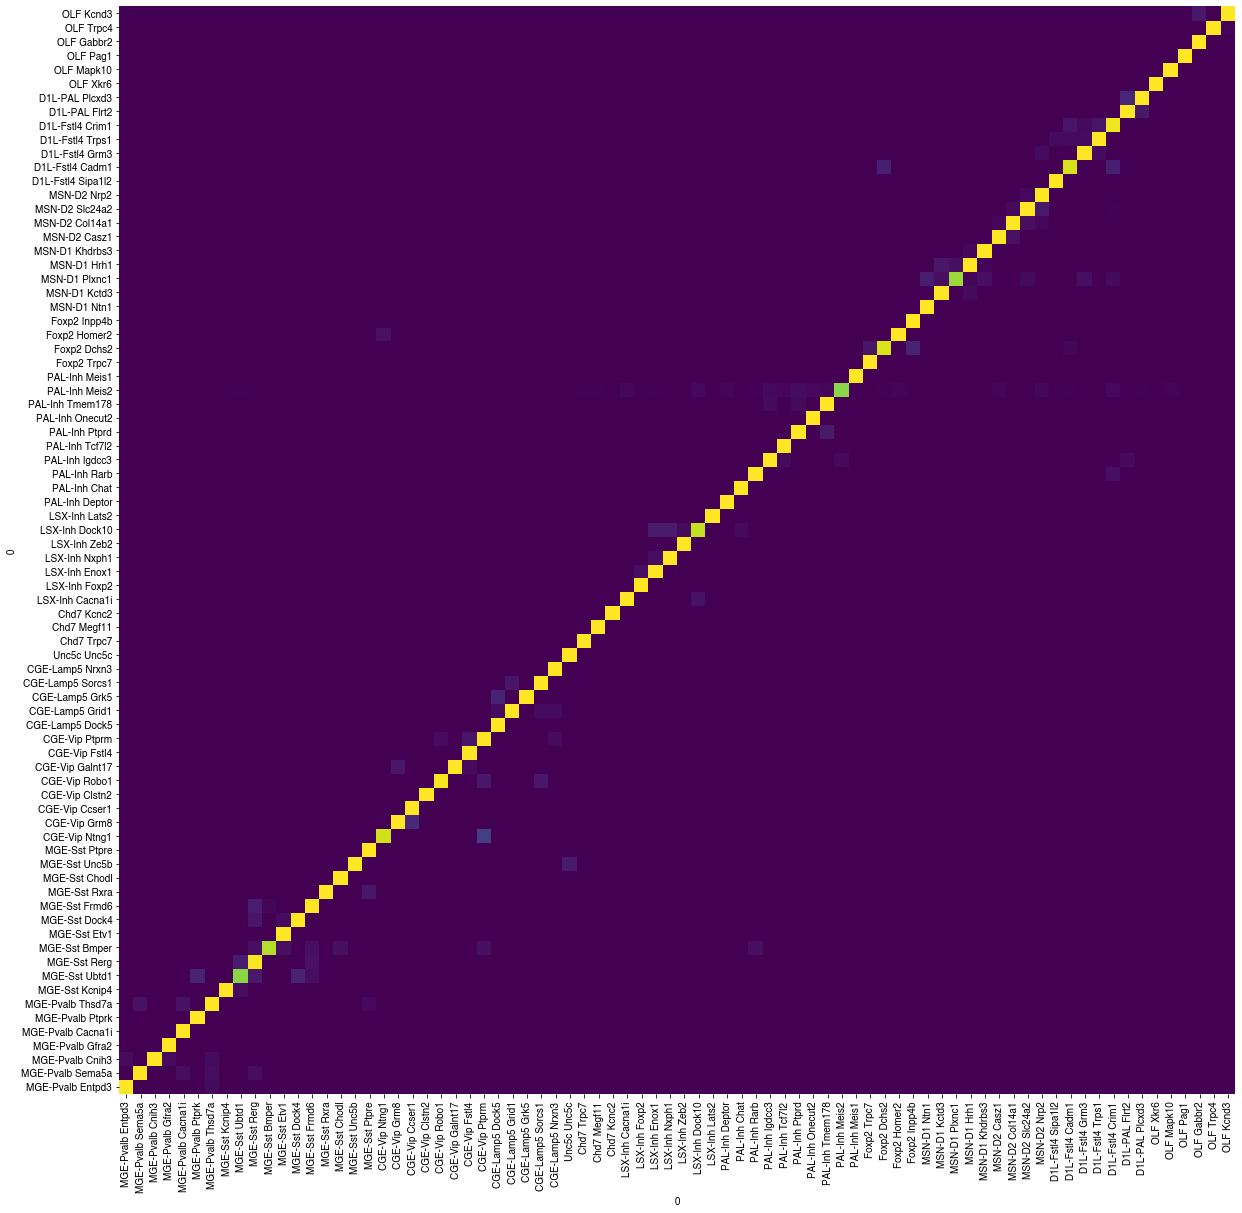

In [64]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(cfm_ratio, cbar=None, vmin=0, vmax=0.9, cmap='viridis')
ax.set(ylim=(0, cfm_ratio.shape[0]))

In [68]:
cluster_order_map = {c: i for i, c in enumerate(cluster_order)}
test_orders = final_pred_proba.index.map(adata.obs[cluster_col]).map(cluster_order_map)
sort_pred_proba = final_pred_proba.iloc[test_orders.argsort(), :]

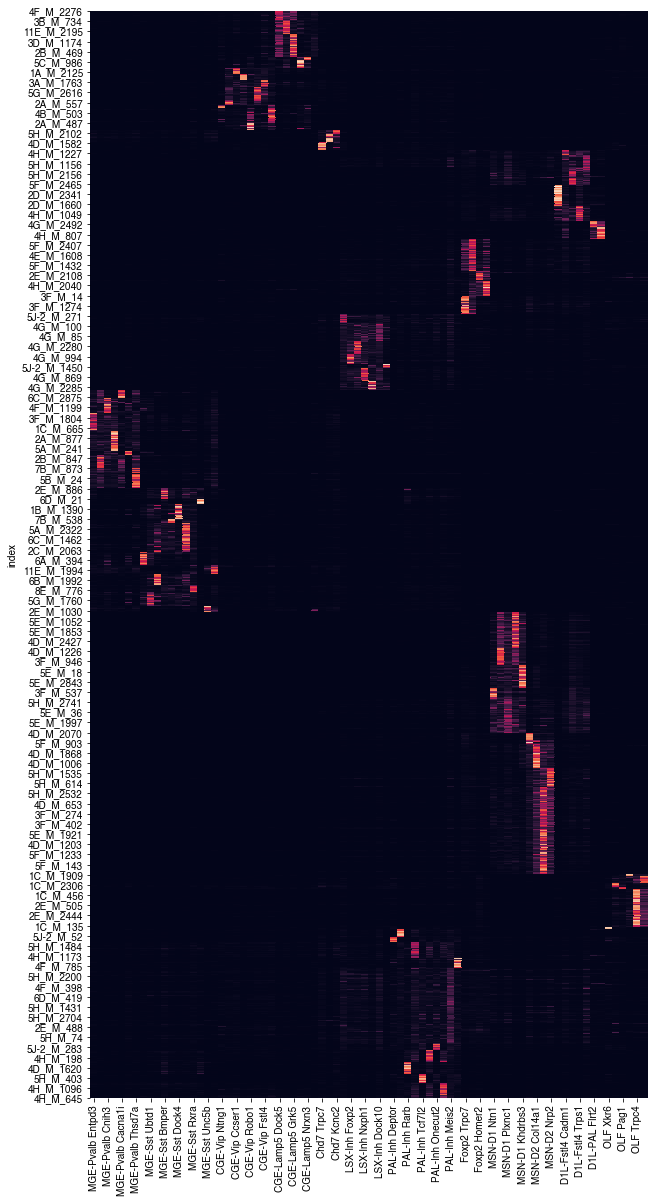

In [69]:
fig, ax = plt.subplots(figsize=(10, 20))
sns.heatmap(sort_pred_proba, ax=ax, cbar=None)

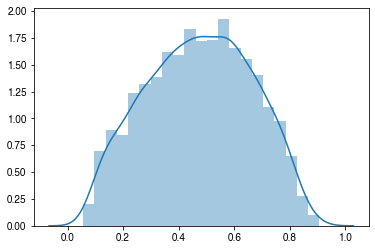

In [77]:
max_proba = []
for cell, cluster in sort_pred_proba.idxmax(axis=1).iteritems():
    max_proba.append(sort_pred_proba.at[cell, cluster])
sns.distplot(max_proba)

In [1]:
with open('finish_flag', 'w') as f:
    f.write('Oh yeah')